<a href="https://colab.research.google.com/github/nimiw0821/DS-GA_1011_NLP/blob/master/HW2/lm_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DS-GA 1011 Homework 2
## N-Gram and Neural Language Modeling

In [1]:
import os
import sys
import json

try:
    import jsonlines
except ImportError:
    print('Installing the package, RESTART THIS CELL')
    !{sys.executable} -m pip install jsonlines

import jsonlines
import numpy as np
from collections import defaultdict

Installing the package, RESTART THIS CELL


## I. N-Gram Language Modeling

#### Utilities

In [0]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

### Additive Smoothing

In [0]:
class NGramAdditive(object):
    def __init__(self, n, delta, vsize):
        self.n = n
        self.delta = delta
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.vsize = vsize
    
    def estimate(self, sequences):
        for sequence in sequences:
            padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
            for i in range(len(padded_sequence) - self.n+1):
                ngram = tuple(padded_sequence[i:i+self.n])
                prefix, word = ngram[:-1], ngram[-1]
                self.count[prefix][word] += 1
                self.total[prefix] += 1
                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        prefix = ngram[:-1]
        word = ngram[-1]
        prob = ((self.delta + self.count[prefix][word]) / 
                (self.total[prefix] + self.delta*self.vsize))
        return prob

In [3]:
datasets, vocab = load_wikitext()

--2019-10-07 18:21:59--  https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.box.com (nyu.box.com)... 185.235.236.197
Connecting to nyu.box.com (nyu.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2019-10-07 18:21:59--  https://nyu.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2019-10-07 18:21:59--  https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.app.box.com (nyu.app.box.com)... 185.235.236.199
Connecting to nyu.app.box.com (nyu.app.box.com)|185.235.236.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.

In [4]:
delta = 0.0005
for n in [2, 3, 4]:
    lm = NGramAdditive(n=n, delta=delta, vsize=len(vocab)+1)  # +1 is for <eos>
    lm.estimate(datasets['train'])

    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Train Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['train'])))
    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Valid Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['valid'])))

NameError: ignored

### I.1 Interpolation

In [0]:
class NGramInterpolation(object):
    def __init__(self, n, alpha, gamma, vsize):
        self.n = n
#         self.lam = lam
        self.alpha = alpha
        self.gamma = gamma
        self.vsize = vsize
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
    
    def estimate(self, sequences):
        for sequence in sequences:
            for n in range(1, self.n+1):
                padded_sequence = ['<bos>']*(n-1) + sequence + ['<eos>']
                for i in range(len(padded_sequence) - n+1):
                    ngram = tuple(padded_sequence[i:i+n])
                    prefix, word = ngram[:-1], ngram[-1]
                    self.count[prefix][word] += 1
                    self.total[prefix] += 1
                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        prefix = ngram[:-1]
        word = ngram[-1]
        
        if self.total[prefix] > 0:
            prob = (self.count[prefix][word] / self.total[prefix]) * self.alpha
        else:
            prob = self.gamma * self.ngram_prob(ngram[1:])
        
#         if len(ngram) >= 2:
#             prob = (self.count[prefix][word] / self.total[prefix]) * self.lam + (1-self.lam)*self.ngram_prob(ngram[1:])
#         elif len(ngram) == 1:
#             prob = (self.count[prefix][word] / self.total[prefix]) * self.lam + (1-self.lam)*1./self.vsize
        return prob

#### Results (showing $\lambda_0,\ldots,\lambda_n$ values):

In [33]:
# n = 2
# for lambda_ in np.linspace(0.1,1,10):
#     lm2 = NGramInterpolation(n=n, lam=lambda_, vsize=len(vocab)+1)  # +1 is for <eos>
#     lm2.estimate(datasets['train'])
#     print("Baseline (Interpolation, n=%d, lambda=%.4f)) Train Perplexity: %.3f" % (n, lambda_, perplexity(lm2, datasets['train'])))
#     print("Baseline (Interpolation, n=%d, lambda=%.4f)) Valid Perplexity: %.3f" % (n, lambda_, perplexity(lm2, datasets['valid'])))

TypeError: ignored

## II. Neural Language Modeling with a Recurrent Neural Network

In [0]:
import torch
import torch.nn as nn

#### Utilities

(Hint: you can adopt the `Dictionary`, dataset loading, and training code from the lab for use here)

In [0]:
try:
    from tqdm import tqdm
except ImportError:
    print('Installing the package, RESTART THIS CELL')
    !{sys.executable} -m pip install tqdm

In [0]:
class Dictionary(object):
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>')
        self.add_token('<eos>')
        self.add_token('<pad>')
        self.add_token('<unk>')
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)

In [0]:
def tokenize_dataset(datasets, dictionary, ngram_order=2):
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

In [8]:
wikitext_dict = Dictionary(datasets, include_valid=True)

# checking some example
print(' '.join(datasets['train'][3010]))

encoded = wikitext_dict.encode_token_seq(datasets['train'][3010])
print(f'\n encoded - {encoded}')
decoded = wikitext_dict.decode_idx_seq(encoded)
print(f'\n decoded - {decoded}')

100%|██████████| 8464/8464 [00:10<00:00, 801.53it/s]

The Nataraja and Ardhanarishvara sculptures are also attributed to the Rashtrakutas .

 encoded - [75, 8816, 30, 8817, 8732, 70, 91, 2960, 13, 6, 8806, 39]

 decoded - ['The', 'Nataraja', 'and', 'Ardhanarishvara', 'sculptures', 'are', 'also', 'attributed', 'to', 'the', 'Rashtrakutas', '.']


In [0]:
# Construct Datasets
import torch
from torch.utils.data import Dataset, RandomSampler, SequentialSampler, DataLoader

class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])

In [0]:
def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    #pad_token = wikitext_dict.get_id('<pad>')
    pad_token = 2
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor

In [11]:
wikitext_tokenized_datasets = tokenize_dataset(datasets, wikitext_dict)
wikitext_tensor_dataset = {}

for split, listoflists in wikitext_tokenized_datasets.items():
    wikitext_tensor_dataset[split] = TensoredDataset(listoflists)
    
# check the first example
wikitext_tensor_dataset['train'][0]

100%|██████████| 9708/9708 [00:00<00:00, 117666.29it/s]


(tensor([[ 0,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10,
          19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]]),
 tensor([[ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10, 19,
          20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1]]))

In [0]:
wikitext_loaders = {}
batch_size = 32
for split, wikitext_dataset in wikitext_tensor_dataset.items():
    wikitext_loaders[split] = DataLoader(wikitext_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)#, drop_last=True)

### II.1 LSTM and Hyper-Parameters

In [0]:
# making a FFNN model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
import torch.nn as nn

class RnnLM(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super(RnnLM, self).__init__()
        self.hidden_dim = options['hidden_dim']
        self.vocab_size = options['vocab_size']
        self.padding_idx = options['padding_idx']
        self.num_layers = options['num_layers']
        self.batch_first = options['batch_first'] # boolean
        self.embed_dim = options['embed_dim']
        self.p = options['dropout']
        
        # create each LM part here 
        self.lookup = nn.Embedding(self.vocab_size, self.embed_dim, self.padding_idx)
        self.rnn = nn.RNN(self.embed_dim, self.hidden_dim, self.num_layers, dropout=self.p, batch_first=self.batch_first)
        self.projection = nn.Linear(self.hidden_dim, self.vocab_size)
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        rnn_outputs, states = self.rnn(embeddings)
        logits = self.projection(rnn_outputs[0])
        
        return logits, states

In [0]:
class LstmLM(torch.nn.Module):
    def __init__(self, options):
        '''
        params:
            @options: dictionary of model parameters
        '''
        super(LstmLM, self).__init__()
        self.hidden_dim = options['hidden_dim']
        self.vocab_size = options['vocab_size']
        self.padding_idx = options['padding_idx']
        self.num_layers = options['num_layers']
        self.batch_first = options['batch_first'] # boolean
        self.embed_dim = options['embed_dim']
        self.p = options['dropout']
        
        self.lookup = nn.Embedding(self.vocab_size, self.embed_dim, self.padding_idx)
        self.lstm = nn.LSTM(self.embed_dim, self.hidden_dim, self.num_layers, batch_first=self.batch_first, dropout=self.p) # lstm takes word embeddings as inputs and outputs hidden states (dim=hidden_dinm)
        self.projection = nn.Linear(self.hidden_dim, self.vocab_size) # linear layer maps from hidden states to word space

    def forward(self, encoded_input_sequence):
        '''
        Forwrad method process the input from token ids to logits
        params:
            @inp: input sentence
        '''
        embedded = self.lookup(encoded_input_sequence)
        lstm_out, states = self.lstm(embedded)
        logits = self.projection(lstm_out)
        return logits, states

In [0]:
# defining what device to use
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

In [0]:
# define model parameters -- options
embed_dim = 64
hidden_dim = 128
num_layers = 2
dropout = 0.1
options = {
    'vocab_size': len(wikitext_dict),
    'embed_dim': embed_dim,
    'padding_idx': wikitext_dict.get_id('<pad>'),
    'hidden_dim': hidden_dim,
    'num_layers': num_layers,
    'dropout': dropout,
    'batch_first': True,
}

#### Results (LSTM vs. Baseline)

In [0]:
def perplexity(loss):
  '''
  function that computes perplexity
  '''
  return 2**(loss/np.log(2))

In [0]:
# now we make same training loop, now with dataset and the model
def train_model(model, model_name, hyperparams, loaders, save=True):
    '''
    function to train neural  LM
    params:
        @model: LM object
        @model_name: str
        @hyperparams: dictionary of hyperparameters set for the model
        @loaders: DataLoader
    '''
    print("Training {}:".format(model_name))
    
    # criterion:
    criterion = nn.CrossEntropyLoss(ignore_index=wikitext_dict.get_id('<pad>'))

    PATH = model_name + '.pth'
    if os.path.exists(PATH): # load pre-trained
        print("PATH exists!")
        checkpoint = torch.load(PATH, map_location=current_device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    else:
      # optimizer:
        model_params = [p for p in model.parameters() if p.requires_grad]
        if hyperparams['optimizer'] == 'SGD':
            optimizer = optim.SGD(model_params, lr=hyperparams['lr'], momentum=hyperparams['momentum'])
        elif hyperparams['optimizer'] == 'Adam':
            optimizer = optim.Adam(model_params, lr=hyperparams['lr'], weight_decay=hyperparams['weight_decay'])

    plot_cache = []
    num_epochs = hyperparams['num_epochs']

    for epoch in range(num_epochs):
        avg_loss=0
        # do train
        model.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits, _ = model(inp)
            # compute loss
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            # back-propogation
            loss.backward()
            # gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
            optimizer.step()
            train_log_cache.append(loss.item()) # store training loss

            if i % 1000 == 0:
                avg_train_loss = sum(train_log_cache)/len(train_log_cache)
                avg_train_perplexity = perplexity(avg_train_loss)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_train_loss, prec=4))
                print('Step {} avg train perplexity = {:.{prec}f}'.format(i, avg_train_perplexity, prec=4))
                train_log_cache = []

        #do validation
        valid_losses = []
        model.eval()
        with torch.no_grad():
            for i, (inp, target) in enumerate(loaders['valid']):
                # current_batch_size = len(inp)
                inp = inp.to(current_device)
                target = target.to(current_device)
                device = torch.device("cuda")
                logits, _ = model(inp)
                # compute loss
                loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
                valid_losses.append(loss.item()) # store validation loss
            avg_val_loss = sum(valid_losses) / len(valid_losses)
            avg_val_perplexity = perplexity(avg_val_loss)
            print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch, avg_val_loss, prec=4))
            print('Validation perplexity after {} epoch = {:.{prec}f}'.format(epoch, avg_val_perplexity, prec=4))

        plot_cache.append((avg_train_loss, avg_val_loss, avg_train_perplexity, avg_val_perplexity))
        # # early stopping
        # if len(plot_cache)>1:
        #   np.abs((plot_cache[epoch][1] - plot_cache[epoch-1][1])/plot_cache[epoch-1][1]) <= 0.0005
        #   print("Meets early stopping criteria: Finish training")
        #   return plot_cache
    
    if save:
        torch.save({
            'epoch':  hyperparams['num_epochs'],
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': plot_cache}, PATH)

    print('Finished training')
    return plot_cache, model

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss(losses):
    epochs = np.array(list(range(len(losses))))
    fig = plt.figure(figsize = (10,5))
    axes = fig.subplots(nrows=1, ncols=2)
    # plot losses
    axes[0].plot(epochs, [i[0] for i in losses], label='Train loss')
    axes[0].plot(epochs, [i[1] for i in losses], label='Val loss')
    axes[0].set_title("Training and Validation losses over time")
    axes[0].set_xlabel("Steps")
    axes[0].set_ylabel("Losses")
    axes[0].legend(loc='best')
    # plot training & validation accuracy
    axes[1].plot(epochs, [i[2] for i in losses], label='Train Perplexity')
    axes[1].plot(epochs, [i[3] for i in losses], label='Val Perplexity')
    axes[1].set_title("Training and Validation perplexity over time")
    axes[1].set_xlabel("Steps")
    axes[1].set_ylabel("Perplexity")
    axes[1].legend(loc='best')

In [23]:
# RNN with baseline hyperparameters
baseline_hyperparams = {
    'optimizer': 'Adam',
    'lr': 0.001,
    'num_epochs': 10,
    'weight_decay': 0
}
model_rnn = RnnLM(options).to(current_device)
print(model_rnn)
base_rnn_losses = train_model(model_rnn, "RNN_LM", baseline_hyperparams, wikitext_loaders)
plot_loss(base_rnn_losses)

RnnLM(
  (lookup): Embedding(33181, 64, padding_idx=2)
  (rnn): RNN(64, 128, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=128, out_features=33181, bias=True)
)
Training RNN_LM:


ValueError: ignored

#### Performance Variation Based on Hyperparameter Values

In [21]:
from sklearn.model_selection import ParameterGrid
from collections import defaultdict

# Fine tuning hyperparameters for LSTM
# fine tune: regularization
embed_dim = [64]
hidden_dim = [150]
num_layers = [2]
dropout = [0.1]
options = {
    'vocab_size': [len(wikitext_dict)],
    'embed_dim': embed_dim,
    'padding_idx': [wikitext_dict.get_id('<pad>')],
    'hidden_dim': hidden_dim,
    'num_layers': num_layers,
    'dropout': dropout,
    'batch_first': [True],
}

regularized_hyperparams = {
    'optimizer': ['Adam'],
    'lr': [0.001],
    'num_epochs': [5],
    'weight_decay': [0]
}

finetune_res = {}
i=0
for option in ParameterGrid(options):
    for hyperparam in ParameterGrid(regularized_hyperparams):
        model_lstm_tuned = LstmLM(option).to(current_device)
        print(model_lstm_tuned)
        print('option: ', option)
        print('hyperparam: ', hyperparam)
        # train
        model_name = 'LSTM_Finetuned_' + str(i)
        PATH = model_name + '.pth'
        finetune_lstm_losses, finetune_lstm_model = train_model(model_lstm_tuned, model_name, hyperparam, wikitext_loaders)
        finetune_res[model_name]=(finetune_lstm_model, {**option, **hyperparam}, finetune_lstm_losses)
        i+=1

LstmLM(
  (lookup): Embedding(33181, 64, padding_idx=2)
  (lstm): LSTM(64, 150, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=150, out_features=33181, bias=True)
)
option:  {'batch_first': True, 'dropout': 0.1, 'embed_dim': 64, 'hidden_dim': 150, 'num_layers': 2, 'padding_idx': 2, 'vocab_size': 33181}
hyperparam:  {'lr': 0.001, 'num_epochs': 5, 'optimizer': 'Adam', 'weight_decay': 0}
Training LSTM_Finetuned_0:
Step 0 avg train loss = 10.4056
Step 0 avg train perplexity = 33044.2369
Step 1000 avg train loss = 6.8874
Step 1000 avg train perplexity = 979.8819
Step 2000 avg train loss = 6.2637
Step 2000 avg train perplexity = 525.1803
Validation loss after 0 epoch = 5.8435
Validation perplexity after 0 epoch = 344.9678
Step 0 avg train loss = 5.9578
Step 0 avg train perplexity = 386.7751
Step 1000 avg train loss = 5.8660
Step 1000 avg train perplexity = 352.8362
Step 2000 avg train loss = 5.7300
Step 2000 avg train perplexity = 307.9746
Validation loss aft

In [0]:
# find best comb (lowest validation loss)
# sorted(finetune_res.items(), key=lambda x: x[1][1][-1][1])[0]
best_model=model_lstm_tuned

### II.2 Learned Embeddings

#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

In [0]:
try:
    import umap
except:
    !pip install umap-learn

In [24]:
%pylab inline 
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(20,20))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['split']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


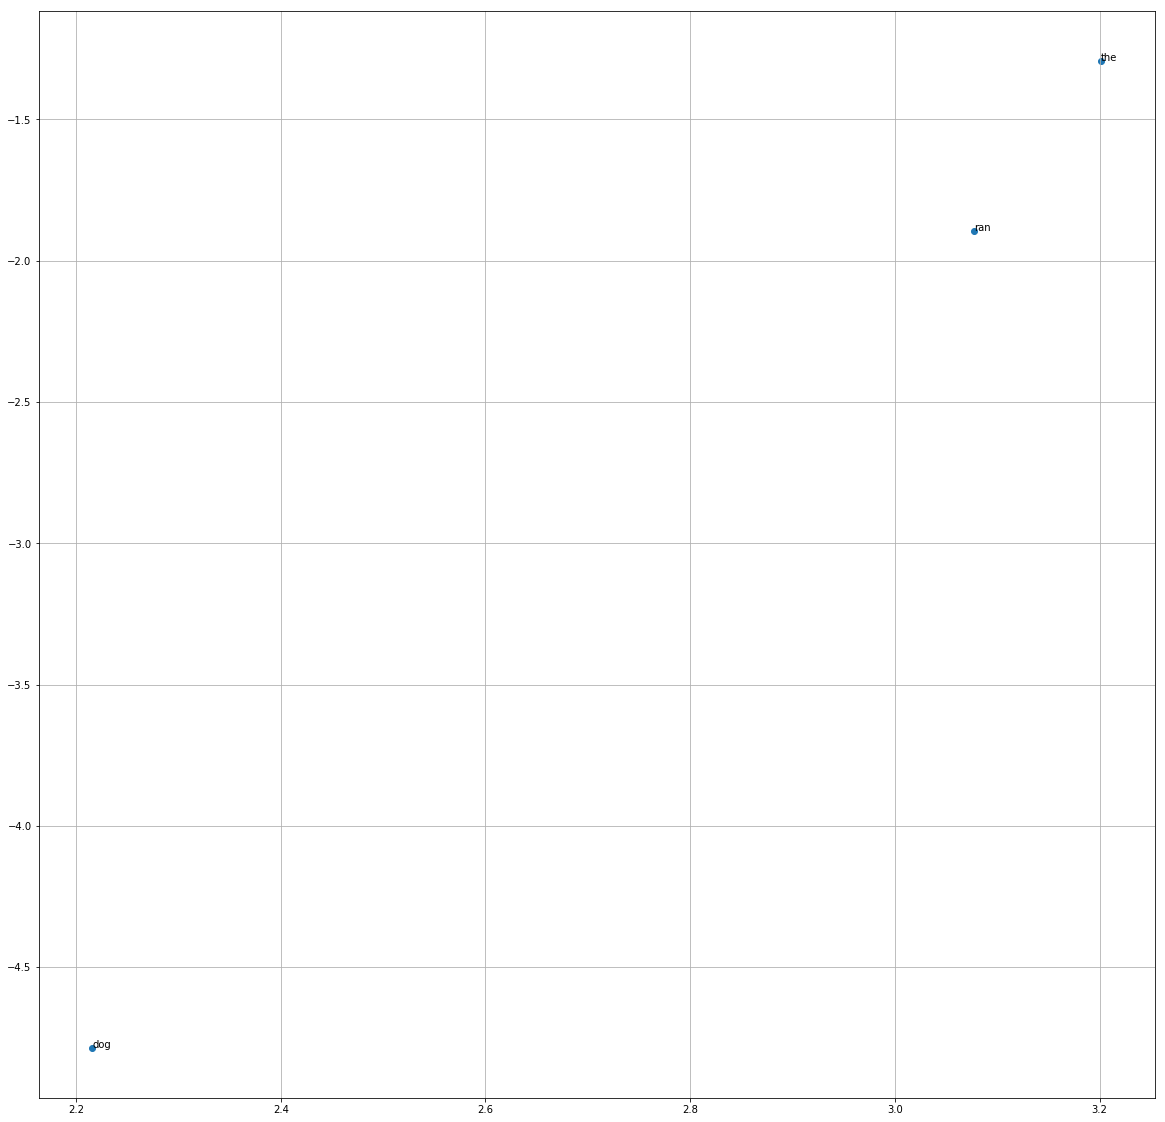

In [89]:
Vsize = 100                                 # e.g. len(dictionary)
d = 32                                      # e.g. model.lookup.weight.size(1) 
fake_weight_matrix = torch.randn(Vsize, d)  # e.g. model.lookup.weight

words = ['the', 'dog', 'ran']
word_ids = [4, 54, 20]                  # e.g. use dictionary.get_id on a list of words

umap_plot(fake_weight_matrix, word_ids, words)

#### II.2.1 Word Similarity

In [0]:
from scipy import spatial

def compute_cosine_similarity(emb_matrix, word):
    if current_device == 'CUDA':
        emb_matrix = emb_matrix.cpu()
    word_idx = wikitext_dict.get_id(word)
    row_distance = torch.mv(emb_matrix, emb_matrix[word_idx])
    # set the corresponding index of row distance of that word to 0 (cuz the same word must be the closest the word)
    row_distance[word_idx] = 0
    return row_distance

In [94]:
PATH = 'LSTM_Finetuned_0.pth'
best_model_dict = torch.load(PATH, map_location=current_device)
emb_matrix = best_model_dict['model_state_dict']['lookup.weight']
words = ['the', 'run', 'dog', 'where', 'quick']
words_ids = [wikitext_dict.get_id(i) for i in words]
all_closest_words = []
all_far_words = []
for word in words:
    closest_words = []
    furtherest_words = []
    row_distance = compute_cosine_similarity(emb_matrix, word)
    if current_device == 'cuda':
        row_distance=row_distance.cpu()
    for i in row_distance.numpy().argsort()[-10:][::-1]:
        closest_words.append(wikitext_dict.get_token(i))
    for i in row_distance.numpy().argsort()[:10]:
        furtherest_words.append(wikitext_dict.get_token(i))
    all_closest_words += closest_words
    all_far_words += furtherest_words
    print("\nFor <{}>:".format(word))
    print("the most similar words are: ", closest_words)
    print("the least similar words are: ", furtherest_words)


For <the>:
the most similar words are:  ['Galilean', 'tropical', 'L.', 'facial', 'Provisional', 'whose', 'ossified', 'their', 'prebendary', 'arid']
the least similar words are:  ['contraction', 'belongs', 'amount', 'recognition', 'Consequently', 'refer', 'accusation', 'due', 'tenths', 'arcades']

For <run>:
the most similar words are:  ['lukewarm', 'herbs', 'surrounded', 'vacations', 'Tools', 'grinder', 'unable', 'culminating', 'anatomy', 'Fat']
the least similar words are:  ['Score', 'Hidalgo', 'invaders', 'rimu', 'may', 'Grand', 'later', 'Libya', 'Get', 'professionalisation']

For <dog>:
the most similar words are:  ['Em', 'Vickie', 'realised', 'attested', 'MOBA', 'PCG', 'Krasinski', 'docile', '979', 'Woody']
the least similar words are:  ['faintest', 'sandwich', 'shrine', 'mm', 'Unofficial', 'exemplifies', 'kāla', 'Rarely', 'Communist', 'eighties']

For <where>:
the most similar words are:  ['as', 'attributes', 'representing', 'while', 'rendezvous', 'dislikes', 'commissioned', 'end

#### II.2.2 Embedding Layer

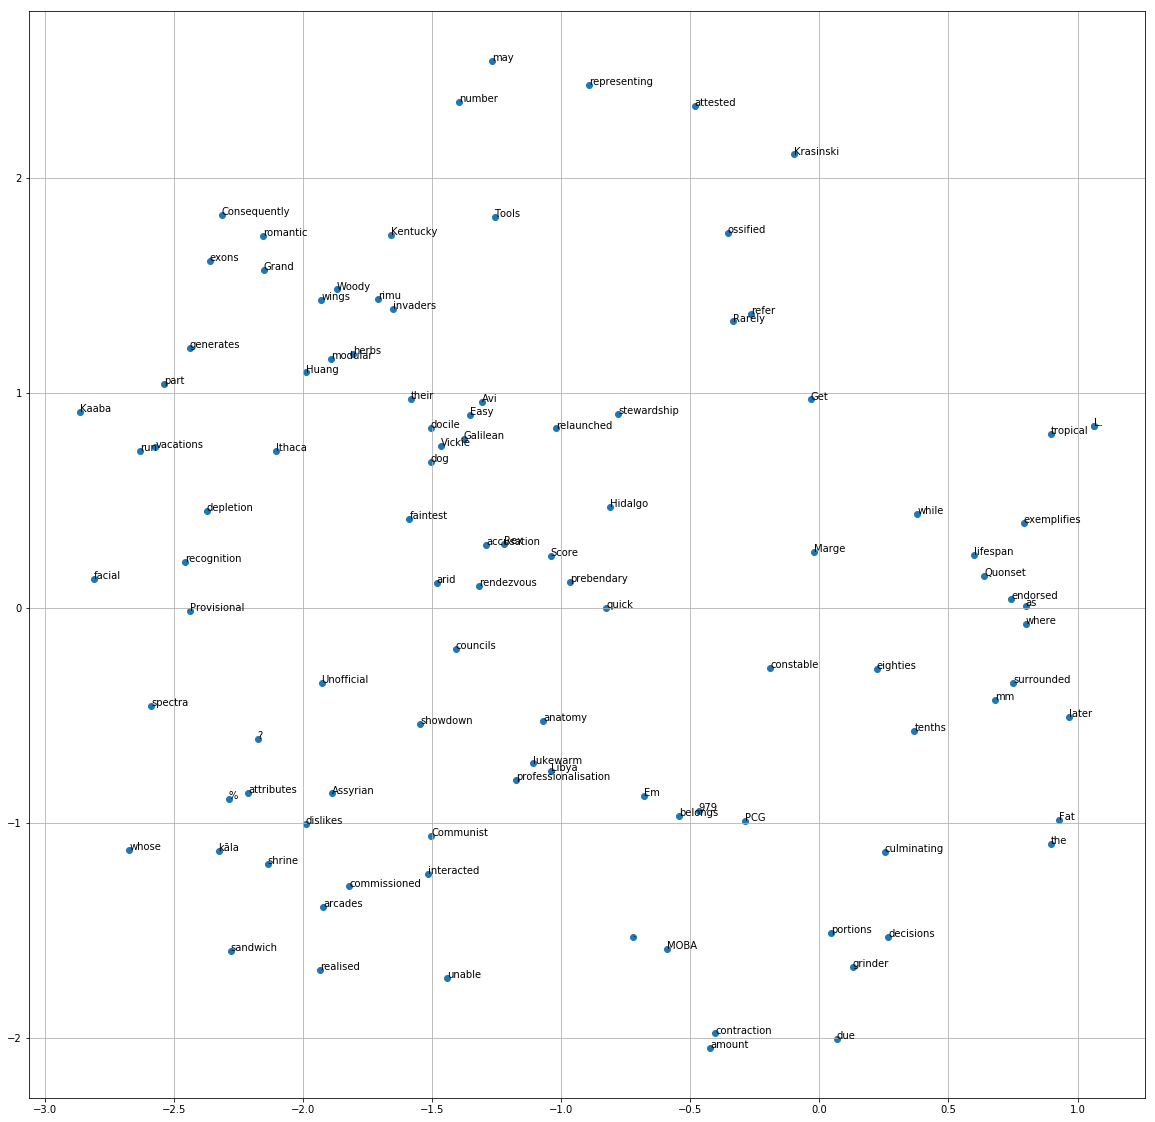

In [96]:
words_selected = words + all_closest_words + all_far_words
words_selected_ids = [wikitext_dict.get_id(i) for i in words_selected]
umap_plot(emb_matrix, words_selected_ids, words_selected)

#### II.2.3 Projection Layer

In [0]:
emb_matrix2 = best_model_dict['model_state_dict']['projection.weight']
all_closest_words2 = []
all_far_words2 = []
for word in words:
  closest_words2 = []
  furtherest_words2 = []
  row_distance = compute_cosine_similarity(emb_matrix, word)
  if current_device == 'cuda':
    row_distance=row_distance.cpu()
  for i in row_distance.numpy().argsort()[-10:][::-1]:
    closest_words2.append(wikitext_dict.get_token(i))
  for i in row_distance.numpy().argsort()[10:]:
    furtherest_words2.append(wikitext_dict.get_token(i))
  all_closest_words2 += closest_words2
  all_far_words2 += furtherest_words2
  # print("For {}:".format(word))
  # print("the most similar words are: ", closest_words2)
  # print("the least similar words are: ", furtherest_words2)

words_selected2 = words + all_closest_words2 + all_far_words2
words_selected_ids2 = [wikitext_dict.get_id(i) for i in words_selected2]

In [0]:
umap_plot(emb_matrix2, words_selected_ids2, words_selected2)

/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


Discussion of Results:


### II.3 Scoring

In [0]:
def compute_seq_score(seq, model):
  seq_id = wikitext_dict.encode_token_seq(seq)
  inp = [[wikitext_dict.get_id("<bos>")]+seq_id]
  target = seq_id + [wikitext_dict.get_id("<eos>")]

  with torch.no_grad():
    model.eval()
    logits, _ = model(torch.tensor(inp, dtype=torch.long).to(current_device))
    # print(logits.shape)

  score = 0
  for idx in range(len(target)):
    prob = F.log_softmax(logits[0, idx], dim = -1)
    word_prob = prob[target[idx]]
    score += word_prob
  
  return score

#### II.3.2 
Highest and Lowest scoring sequences

In [0]:
scores = {} # key: sequence, value: score
for seq in datasets['valid']:
  scores[" ".join(seq)] = compute_seq_score(seq, best_model)

In [0]:
top_scores = {seq:score for (seq, score) in sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10]}
lowest_scores = {seq: score for (seq, score) in sorted(scores.items(), key=lambda x: x[1])[:10]}

In [64]:
top_scores

{'= = = <unk> from the stage = = =': tensor(-28.2707, device='cuda:0'),
 '= = = Army returns = = =': tensor(-26.9778, device='cuda:0'),
 '= = = Hit list = = =': tensor(-26.7051, device='cuda:0'),
 '= = = Scientology sources = = =': tensor(-24.4416, device='cuda:0'),
 '= = Culture and the arts = =': tensor(-29.0972, device='cuda:0'),
 '= = Early life and education = =': tensor(-22.5725, device='cuda:0'),
 '= = Post @-@ war career = =': tensor(-20.3305, device='cuda:0'),
 '= = Post @-@ war period = =': tensor(-21.2977, device='cuda:0'),
 '= = Return to New Zealand = =': tensor(-28.6081, device='cuda:0'),
 'unk> in the second half of the 7th century .': tensor(-27.5374, device='cuda:0')}

In [65]:
lowest_scores

{'> Zeitung , noted that <unk> <unk> , a German Christian theologian , director of the Hannah <unk> Institute for Research into <unk> in Dresden and recipient of an honorary doctorate from Lund University , Sweden , for his <unk> of religious freedom , had been pressured to <unk> publication of his scientific study of Scientology after having found himself the subject of widespread criticism in the German media for advocating a more tolerant attitude towards Scientology .': tensor(-461.7574, device='cuda:0'),
 'Adrien Begrand of PopMatters remarked that " There \'s no better song to kick things off than the <unk> \' Angel of Death \' , one of the most monumental songs in metal history , where guitarists Kerry King and Jeff Hanneman deliver their intricate riffs , drummer Dave Lombardo performs some of the most powerful drumming ever recorded , and bassist / vocalist Tom Araya screams and <unk>': tensor(-448.1323, device='cuda:0'),
 'Besides the <unk> anime and manga , <unk> is featured

#### II.3.3 Modified sequences

In [72]:
for random_id in np.random.choice(len(wikitext_dict), 3):
  print(wikitext_dict.get_token(random_id))

encode
imported
Oak


In [108]:
seq = '= = Culture and the arts = ='
print(seq, compute_seq_score(seq.split(" "), best_model))
for i in ['education', 'life', 'people', '=']:
  seq_lst = seq.split(" ")
  seq_lst[5] = i
  print(" ".join(seq_lst), compute_seq_score(seq_lst, best_model))

= = Culture and the arts = = tensor(-29.0972, device='cuda:0')
= = Culture and the education = = tensor(-29.1664, device='cuda:0')
= = Culture and the life = = tensor(-26.2092, device='cuda:0')
= = Culture and the people = = tensor(-27.2789, device='cuda:0')
= = Culture and the = = = tensor(-27.7176, device='cuda:0')


Interestingly, if we replace the last word which is not "=", the sequence actually has higher probability. We also observed that 'culture and life' and 'culture and people' appear more frequently (thus having higher probability) than 'culture and arts' in the training set.

### II.4 Sampling

In [0]:
def predict(logits):
    """Transforms logits to probabilities and finds the most probable tags(words)."""
    # Create softmax (F.softmax) function
    softmax_output = F.softmax(logits[0,0], dim=0)
    predictions = torch.multinomial(softmax_output.flatten(), num_samples=1)
    return predictions

In [88]:
# initialize states and word
# states = torch.zeros(best_model.num_layers, 1, best_model.hidden_dim)
word = '<bos>'
samples = []
sentence = ''
for _ in tqdm(range(1000)): # generate 1000 sequences
  with torch.no_grad():
    best_model.eval() # eval mode
    while word is not '<eos>':
      word_encoded = torch.tensor([wikitext_dict.get_id(word)]).view(1, 1).to(current_device)
      logits, _ = best_model(word_encoded)
      word = wikitext_dict.get_token(predict(logits))
      sentence += ' '
      sentence += word
    print(sentence)
    samples.append(sentence)


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [0]:
# randomly sample 1000 examples from the validation set
from random import sample 
valid_samples = sample(datasets['valid'], 1000)

#### II.4.3 Number of unique tokens and sequence length 

(1,000 samples vs. 1,000 randomly selected validation-set sequences)

4915
88
8


(array([286., 317., 221., 104.,  34.,  23.,   8.,   5.,   1.,   1.]),
 array([ 8., 16., 24., 32., 40., 48., 56., 64., 72., 80., 88.]),
 <a list of 10 Patch objects>)

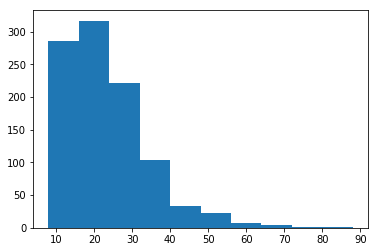

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

# validation set
all_words_valid = [word for lst in valid_samples for word in lst]
num_unique_valid = len(set(all_words_valid))
print(num_unique_valid)
seq_len_valid = [len(lst) for lst in valid_samples]
print(max(seq_len_valid))
print(min(seq_len_valid))
plt.hist(seq_len_valid)

#### II.4.4 Example Samples